In [9]:
import scipy.io
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [10]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [11]:
class WaterQualitySequenceDataset(Dataset):
    def __init__(self, mat_file, input_seq_len=10, forecast_horizon=1, train=True, transform=None):
        import scipy.io

        self.input_seq_len = input_seq_len
        self.forecast_horizon = forecast_horizon
        self.transform = transform

        # Load the .mat file
        data = scipy.io.loadmat(mat_file)

        # Group info
        location_group = data['location_group']
        location_ids = data['location_ids'].flatten()
        num_stations = len(location_ids)

        group_ids = np.zeros(num_stations, dtype=np.float32)
        for i in range(location_group.shape[1]):
            indices = location_group[0, i].flatten() - 1  # to 0-based
            group_ids[indices] = i + 1
        self.group_ids = torch.tensor(group_ids, dtype=torch.float32).unsqueeze(1)  # shape: (37, 1)

        # Select train/test data
        if train:
            X_raw = data['X_tr']  # shape (1, N), cells of (37, 11)
            Y_raw = data['Y_tr']  # shape (37, N)
        else:
            X_raw = data['X_te']
            Y_raw = data['Y_te']

        # Convert to list of tensors
        self.X_seq = [torch.tensor(X_raw[0, i], dtype=torch.float32) for i in range(X_raw.shape[1])]
        self.Y_seq = [torch.tensor(Y_raw[:, i], dtype=torch.float32) for i in range(Y_raw.shape[1])]

        self.total_length = len(self.X_seq)
        self.sequence_length = input_seq_len
        self.target_horizon = forecast_horizon

    def __len__(self):
        # Total sequences = total samples - input_seq_len - forecast_horizon + 1
        return self.total_length - self.sequence_length - self.target_horizon + 1

    def __getitem__(self, idx):
        # Build input sequence
        x_seq = []
        for i in range(idx, idx + self.sequence_length):
            x = self.X_seq[i]
            # Append group info to features → shape (37, 12)
            x = torch.cat((x, self.group_ids), dim=1)
            x_seq.append(x)

        x_seq = torch.stack(x_seq, dim=0)  # shape: (input_seq_len, 37, 12)

        # Get target: shape (forecast_horizon, 37)
        y_seq = torch.stack([
            self.Y_seq[idx + self.sequence_length + i] for i in range(self.target_horizon)
        ], dim=0)  # (H, N)


        if self.transform:
            x_seq = self.transform(x_seq)

        return x_seq, y_seq

dataset = WaterQualitySequenceDataset('water_dataset.mat', input_seq_len=10, forecast_horizon=1, train=True)
x, y = dataset[0]

print(x.shape)  # (10, 37, 12)
print(y.shape)  # (1, 37)

torch.Size([10, 37, 12])
torch.Size([1, 37])


In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-torch.log(torch.tensor(10000.0)) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)  # non-trainable

    def forward(self, x, time_len):
        # x: (batch, seq_len * num_stations, d_model)
        # We repeat each time step's encoding for all stations
        B, S, D = x.shape
        num_stations = S // time_len

        pe = self.pe[:time_len, :].unsqueeze(1).repeat(1, num_stations, 1)  # (time_len, num_stations, d_model)
        pe = pe.reshape(1, time_len * num_stations, D)  # (1, S, D)

        return x + pe.to(x.device)

In [13]:
class WaterQualityTransformer(nn.Module):
    def __init__(self, input_dim=12, d_model=64, nhead=4, num_layers=3, dim_feedforward=128, dropout=0.1,
                 seq_len=10, num_stations=37, forecast_horizon=1, target_col_idx=0):
        super().__init__()

        self.seq_len = seq_len
        self.num_stations = num_stations
        self.forecast_horizon = forecast_horizon
        self.target_col_idx = target_col_idx
        self.forcast_horizon = forecast_horizon
        self.num_stations = num_stations

        self.input_linear = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model=d_model, max_len=seq_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, forecast_horizon * num_stations)

    def forward(self, x):
        # Expecting (B, T, N, F)
        B, T, N, F = x.shape
    
        x = x.view(B, T * N, F)       # flatten spatially: (B, T*N, F)
        x = self.input_linear(x)      # (B, T*N, d_model)
        x = self.pos_encoder(x, time_len=T)  # add time pos enc
        x = x.permute(1, 0, 2)        # (T*N, B, d_model) for transformer
    
        encoded = self.transformer_encoder(x)  # (T*N, B, d_model)
        encoded = encoded.permute(1, 0, 2)     # back to (B, T*N, d_model)
    
        # Aggregate: last token or mean
        summary = encoded[:, -1, :]  # (B, d_model)
    
        y = self.decoder(summary)          # (B, H * N)
        y = y.view(-1, self.forecast_horizon, self.num_stations)  # (B, H, N)
        return y


In [14]:
def train_model(
    model,
    train_loader,
    val_loader=None,
    epochs=20,
    optimizer=None,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    loss_fn=nn.MSELoss(),
    scheduler=None,
    verbose=True,
    forecast_horizon=1
):
    model.to(device)

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0

        for x, y in train_loader:
            x = x.to(device)  # (B, T, N, F)
            y = y.to(device)  # (B, N)

            optimizer.zero_grad()
            output = model(x)  # (B, 1, N)

            # Match shape: (B, 1, N)
            y = y.unsqueeze(1)
            loss = loss_fn(output, y)

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation
        if val_loader:
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for x_val, y_val in val_loader:
                    x_val = x_val.to(device)
                    y_val = y_val.to(device).unsqueeze(1)

                    y_pred = model(x_val)
                    val_loss += loss_fn(y_pred, y_val).item()

            val_loss /= len(val_loader)

        if verbose:
            print(f"Epoch {epoch:2d} | Train Loss: {train_loss:.4f}", end="")
            if val_loader:
                print(f" | Val Loss: {val_loss:.4f}")
            else:
                print()

        if scheduler:
            scheduler.step()

In [15]:
# File path for the dataset
mat_file_path = 'water_dataset.mat'
forecast_horizon = 7

# Load dataset
train_dataset = WaterQualitySequenceDataset(mat_file_path, train=True, forecast_horizon=forecast_horizon)
test_dataset = WaterQualitySequenceDataset(mat_file_path, train=False, forecast_horizon=forecast_horizon)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [17]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

model = WaterQualityTransformer(seq_len=10, forecast_horizon=forecast_horizon)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_model(model, train_loader, test_loader, optimizer=optimizer, epochs=10)

C:\Users\amart\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([32, 1, 7, 37])) that is different to the input size (torch.Size([32, 7, 37])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\amart\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([23, 1, 7, 37])) that is different to the input size (torch.Size([23, 7, 37])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\amart\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([10, 1, 7, 37])) that is different to the input size (torch.Size([10

Epoch  1 | Train Loss: 0.3753 | Val Loss: 0.0860
Epoch  2 | Train Loss: 0.0420 | Val Loss: 0.0100
Epoch  3 | Train Loss: 0.0174 | Val Loss: 0.0061
Epoch  4 | Train Loss: 0.0110 | Val Loss: 0.0016
Epoch  5 | Train Loss: 0.0083 | Val Loss: 0.0012
Epoch  6 | Train Loss: 0.0074 | Val Loss: 0.0011
Epoch  7 | Train Loss: 0.0068 | Val Loss: 0.0011
Epoch  8 | Train Loss: 0.0062 | Val Loss: 0.0011
Epoch  9 | Train Loss: 0.0058 | Val Loss: 0.0009
Epoch 10 | Train Loss: 0.0054 | Val Loss: 0.0008


In [18]:
def plot_forecast_vs_true(y_true, y_pred, station_idx=0, sample_idx=0):
    y_true_np = y_true[sample_idx, 0, :, station_idx].cpu().numpy()
    y_pred_np = y_pred[sample_idx, :, station_idx].cpu().numpy()

    plt.figure(figsize=(10, 4))
    plt.plot(y_true_np, label='True', marker='o')
    plt.plot(y_pred_np, label='Predicted', marker='x')
    plt.title(f'Station {station_idx}, Sample {sample_idx}')
    plt.xlabel('Forecast Horizon')
    plt.ylabel('Water Quality')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [19]:
def plot_mse_per_horizon(y_true, y_pred):
    """
    Plots MSE over forecast horizon.

    Args:
        y_true: (B, H, N)
        y_pred: (B, H, N)
    """
    # Ensure tensors are on CPU and detached
    y_true = y_true.detach().cpu()
    y_pred = y_pred.detach().cpu()

    H = y_true.shape[2]
    mse_per_horizon = []

    for h in range(H):
        mse = F.mse_loss(y_pred[:, h, :], y_true[:, 0, h, :])
        mse_per_horizon.append(mse.item())

    plt.figure(figsize=(8, 4))
    plt.plot(range(1, H + 1), mse_per_horizon, marker='o')
    plt.title('MSE per Forecast Horizon')
    plt.xlabel('Forecast Step (H)')
    plt.ylabel('MSE')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


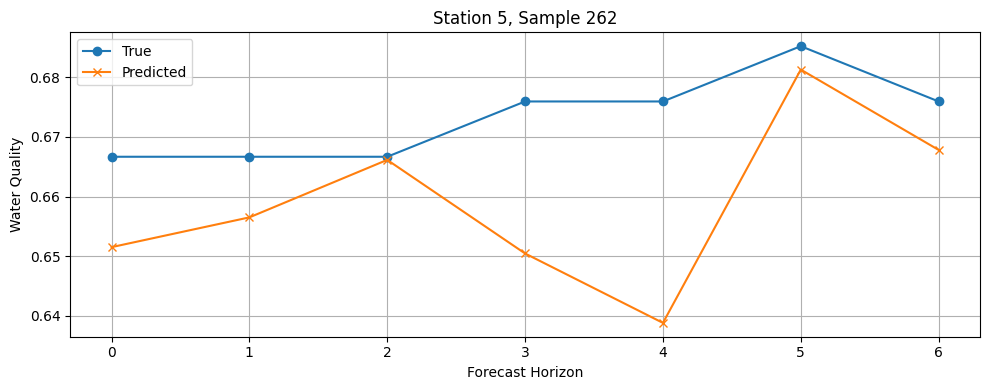

In [23]:
# Move model to evaluation mode and inference device
model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Containers for true and predicted values
all_y_true = []
all_y_pred = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        preds = model(x_batch)  # (B, 1, N)
        # Ensure both y and preds have shape (B, H, N)
        y_batch = y_batch.unsqueeze(1)
        all_y_true.append(y_batch.cpu())
        all_y_pred.append(preds.cpu())

# Concatenate all batches into single tensors: (total_samples, H, N)
y_true_full = torch.cat(all_y_true, dim=0)
y_pred_full = torch.cat(all_y_pred, dim=0)
plot_forecast_vs_true(y_true_full, y_pred_full, station_idx=5, sample_idx=262)

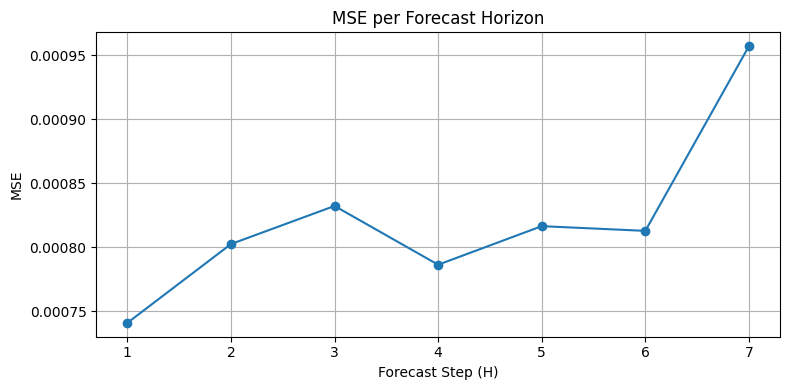

In [21]:
plot_mse_per_horizon(y_true_full, y_pred_full)